## Libraries

In [13]:
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

import matplotlib.pyplot as plt
# import graphviz
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pickle
import graphviz

In [14]:
# import plotly.express as px
import cufflinks as cf
cf.go_offline()

In [15]:
# from sklearn.model_selection import train_test_split
# from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
%run ..\..\Data\triangulars.ipynb
%run ..\Function.ipynb

## Functions

In [17]:
# custom metric
def _mape(y, y_pred, w):
    diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),np.maximum(0.001, y)))
    
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

In [18]:
cos_7 = make_function(function=CustomSC.cos_7, name='cos_7', arity=1)

sin_7 = make_function(function=CustomSC.sin_7, name='sin_7', arity=1)

cos_365 = make_function(function=CustomSC.cos_365, name='cos_365', arity=1)

sin_365 = make_function(function=CustomSC.sin_365, name='sin_365', arity=1)

abscos_14 = make_function(function=CustomSC.abscos_14, name='abscos_14', arity=1)

abssin_14 = make_function(function=CustomSC.abssin_14, name='abssin_14', arity=1)

In [19]:
def one(x1):
    return np.ones(len(x1))

one = make_function(function = one, 
                    name = 'one', 
                    arity = 1,
                     wrap = True)

In [20]:
def time(x1):
    return np.arange(1, len(x1)+1)

time = make_function(function = time,
                    name = 'time',
                    arity = 1,
                     wrap = True)

## Load data

In [21]:
path_consumo = Path().resolve().parents[1] / "Data" / "Data1.xlsx"
consumo = pd.read_excel(path_consumo)
consumo = consumo.set_index("fecha").loc["2007-01-01":"2020-03-30"]

In [22]:
festivos=pd.read_excel(Path().resolve().parents[1] / "Data" /"Festivos.xlsx")
festivos2=pd.read_excel(Path().resolve().parents[1] / "Data" / "Festivos2.xlsx")

In [23]:
fest = triangulars().festivos(X = consumo, festivos = festivos, festivos2 = festivos2)

In [24]:
t = np.arange(1, consumo.size+1).reshape(-1, 1)
day = consumo.index.dayofyear
wend=consumo.index.weekday
wday=consumo.index.weekday
weekd = consumo.index.weekday
month = consumo.index.month

weekd1 = pd.get_dummies(weekd, prefix = "wday", drop_first = True)
weekd1.index = consumo.index
monthd = pd.get_dummies(month, prefix = "mn", drop_first = True)
monthd.index = consumo.index

X = triangulars().diffseason(consumo)
# X1 = triangulars().diffclima(consumo)
X = pd.concat([X, weekd1], axis = 1)
X = pd.concat([X, fest], axis = 1)

X["t"] = t
X["day"] = day
X["weekd"] = weekd
X["month"] = month
X["wend"]=wend
X["wday"]=wday
X["wend"] = X["wend"].replace([0,1,2,3,4,5,6],[.5,0,0,0,.5,1,1])
X["wday"] = X["wday"].replace([0,1,2,3,4,5,6],[.5,1,1,1,.5,0,0])

In [25]:
X1 = triangulars().diffseason(consumo)
X1["t"] = t/t.max()
X1["day"] = day/day.max()

In [26]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(t.reshape(-1, 1), consumo, test_size = 365, shuffle = False)

# X_train = X_train1.to_numpy(); X_test = X_test1.to_numpy()

scaler = MaxAbsScaler(); scaler.fit(X_train1)
X_train = scaler.transform(X_train1)
X_test = scaler.transform(X_test1)

scaler1 = MaxAbsScaler(); scaler1.fit(y_train1)
y_train = scaler1.transform(y_train1).reshape(-1)
y_test = scaler1.transform(y_test1).reshape(-1)

## Fit

In [28]:
/SymbolicRegressor

SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div'), generations=20,
                  init_depth=(2, 6), init_method='half and half',
                  low_memory=False, max_samples=1.0,
                  metric='mean absolute error', n_jobs=1, p_crossover=0.9,
                  p_hoist_mutation=0.01, p_point_mutation=0.01,
                  p_point_replace=0.05, p_subtree_mutation=0.01,
                  parsimony_coefficient=0.001, population_size=1000,
                  random_state=None, stopping_criteria=0.0, tournament_size=20,
                  verbose=0, warm_start=False)

In [58]:
model = SymbolicRegressor(population_size=2000, init_method = "full",
                           p_crossover=0.5, p_subtree_mutation = 0.3, p_hoist_mutation = 0.01, p_point_mutation = 0.15,
                           warm_start = True,
                           function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'abs', 'sqrt', 'log', cos_7, one, 
                                         time, sin_7, cos_365, sin_365, abscos_14, abssin_14),
#                                 feature_names = [*X.columns],
#                            metric = mape,
                           max_samples = 0.95,
                           generations=100, stopping_criteria=0.01, parsimony_coefficient=0.00001,
                           verbose=1, random_state=0)


In [59]:
model.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.55           3642.6       10         0.049993        0.0495773      5.64m
   1     6.71          24.9547       20         0.047938        0.0460948      6.94m
   2     7.46          14.5334       15        0.0473905        0.0447085      6.67m
   3     8.95          24.8933       15        0.0471393        0.0494515      7.17m
   4    11.79          27.1932       14        0.0470033        0.0520425      8.00m
   5    12.77          25.9743       18         0.045508        0.0457194      7.87m
   6    15.33          3352.36       23        0.0431569        0.0435857      8.86m
   7    17.60          27.4078       23        0.0426841        0.0440337      9.86m
   8    21.75          37.4347       28        0.0423062        0.0436439  

  94   101.46          58.4076      105        0.0265068        0.0309245      1.59m
  95   101.33           56.079      106        0.0264904        0.0312361      1.29m
  96   101.03          67.3498      104        0.0265373        0.0323831     58.23s
  97   101.85          64.0046      192         0.026458        0.0318513     37.94s
  98   102.10           41.624      105        0.0264468        0.0320635     18.91s
  99   102.21          61.7969      119        0.0265107        0.0328867      0.00s


SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'abs',
                                'sqrt', 'log',
                                <gplearn.functions._Function object at 0x000001E79AD3A54...
                  generations=100, init_depth=(2, 6), init_method='full',
                  low_memory=False, max_samples=0.95,
                  metric='mean absolute error', n_jobs=1, p_crossover=0.5,
                  p_hoist_mutation=0.01, p_point_mutation=0.15,
                  p_point_replace=0.05, p_subtree_mutation=0.3,
                  parsimony_coefficient=1e-05, population_size=2000,
                  random_state=0, stopping_criteria=0.01, tournament_size=20,
                  verbose=1, warm_start=True)

In [60]:
print(model._program)

add(sin_365(sin(sin(add(sub(abssin_14(time(X0)), cos_7(time(0.867))), sqrt(sqrt(abssin_14(time(X0)))))))), add(sin_365(sin(sqrt(sin_365(time(abscos_14(sin_365(sub(add(sin(sin_7(cos_365(X0))), 0.407), cos_7(time(X0)))))))))), add(sin_365(sqrt(sqrt(abssin_14(time(X0))))), add(sin_365(sin(div(-0.314, X0))), add(sin_365(sub(sqrt(sqrt(abssin_14(time(time(sin_365(X0)))))), cos_365(time(X0)))), add(sin_365(sin(div(-0.314, sin_7(X0)))), add(sin_365(sub(sqrt(sin_365(time(log(cos(X0))))), abscos_14(div(-0.995, sin_7(X0))))), add(sin_365(sin(log(X0))), add(sin_365(sub(add(sin_365(time(one(sin_7(cos(X0))))), sqrt(sqrt(abssin_14(time(cos_365(abs(log(mul(sub(0.219, -0.689), cos(0.151)))))))))), cos_7(time(X0)))), sin_7(sin(add(sin_7(X0), 0.676))))))))))))


In [145]:
print(model._program)

sin_7(abscos_14(sub(sqrt(sub(add(wday_6, abssin_14(mul(sub(day, Invierno1), abscos_14(time(Constitucion))))), sub(t, 0.699))), sub(t, 0.699))))


## Predict

### Plot residual

#### Test

In [691]:
pred = model.predict(X_test)

In [692]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [121]:
plotting = pd.DataFrame(pred1, index = y_test1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_residual_pred.reshape(-1, 1))
# plotting["real"] = y_residual_pred

NameError: name 'y_residual_pred' is not defined

In [122]:
# pd.DataFrame(pred1).iplot()

In [123]:
plotting[["real", "prediction"]].iplot()

KeyError: "['real'] not in index"

In [43]:
plotting[["real", "prediction"]].iplot()

In [44]:
(plotting.real - plotting.prediction ).iplot(title = "residual")

#### Train

In [45]:
pred = model.predict(X_train)

In [46]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [47]:
# plotting = pd.DataFrame(pred1, index = y_train1.index, columns = ["prediction"])
# plotting["real"] = scaler1.inverse_transform(y_train.reshape(-1, 1))

In [48]:
plotting = pd.DataFrame(pred1, index = y_train1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_residual.reshape(-1, 1))

In [49]:
plotting[["real", "prediction"]].iplot()

In [761]:
plotting[["real", "prediction"]].iplot()

In [762]:
(plotting.real - plotting.prediction).iplot(title = "residual")

In [763]:
np.mean(np.abs((y_train - pred)/y_train))*100

99.66836704904847

### Plot residuals + predict

#### Test

In [764]:
pred = model.predict(X_test) + y_res_pred

In [765]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [766]:
plotting = pd.DataFrame(pred1, index = y_test1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_test.reshape(-1, 1))

In [767]:
plotting[["real", "prediction"]].iplot()

In [768]:
(plotting.real - plotting.prediction ).iplot(title = "residual")

In [769]:
np.mean(np.abs((plotting.real - plotting.prediction)/plotting.real))*100

2.8184639481007827

#### Train

In [630]:
pred = model.predict(X_train) + y_res

In [631]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [632]:
plotting = pd.DataFrame(pred1, index = y_train1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_train.reshape(-1, 1))

In [633]:
plotting[["real", "prediction"]].iplot()

In [634]:
(plotting.real - plotting.prediction).iplot(title = "residual")

In [635]:
np.mean(np.abs((y_train - pred)/y_train))*100

3.2254174965825735

In [636]:
print(model._program)

abssin_14(sin_365(mul(sub(sin_7(sub(sub(cos_7(sin_365(X0)), cos_365(mul(X0, sin(cos_7(sin(-0.391)))))), cos_365(mul(X0, abssin_14(0.160))))), cos_365(mul(X0, 0.089))), mul(sin_7(mul(sin_7(sin_365(X0)), sub(sub(cos_7(abssin_14(0.160)), cos_365(mul(X0, sin(cos(cos_7(sin_7(0.559))))))), cos_365(mul(X0, 0.089))))), sub(sub(cos_7(abssin_14(X0)), cos_365(mul(X0, 0.089))), cos_365(mul(X0, 0.089)))))))


### plot real value

#### Test

In [61]:
pred = model.predict(X_test)

In [62]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [63]:
plotting = pd.DataFrame(pred1, index = y_test1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_test.reshape(-1, 1))

In [64]:
plotting[["real", "prediction"]].iplot()

In [65]:
(plotting.real - plotting.prediction ).iplot(title = "residual")

In [66]:
np.mean(np.abs((plotting.real - plotting.prediction)/plotting.real))*100

5.515940474828267

#### Train

In [67]:
pred = model.predict(X_train)

In [68]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [69]:
plotting = pd.DataFrame(pred1, index = y_train1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_train.reshape(-1, 1))

In [70]:
plotting[["real", "prediction"]].iplot()

In [57]:
(plotting.real - plotting.prediction).iplot(title = "residual")

## np.mean(np.abs((y_train - pred)/y_train))*100

In [867]:
print(model._program)

abssin_14(add(add(cos_7(wday_6), add(abssin_14(add(mul(sub(t, Jue santo), sub(sub(div(virgen, año viejo), sqrt(Navidad)), sqrt(Navidad))), add(add(t, sin_7(log(cos_7(Vie santo)))), add(abssin_14(add(t, div(sin_7(0.118), sab santo))), add(sin_7(0.118), mul(add(add(add(add(add(sin(add(wday_5, Trabajo)), add(NewYear, Grito)), add(NewYear, Grito)), Constitucion), Navidad), Constitucion), sub(cos(abscos_14(sin(wday_5))), cos_7(wday_6)))))))), add(sin_7(0.118), mul(sin_7(weekd), 0.118)))), sqrt(log(abscos_14(add(log(cos_7(add(sin_365(add(t, add(add(t, div(sin_7(0.118), sab santo)), div(time(wday_5), sab santo)))), verano))), Primavera))))))


## Visualize

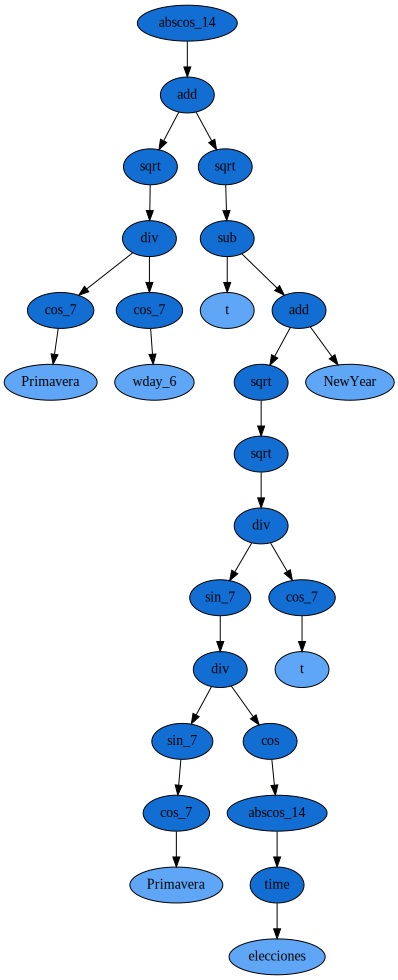

In [708]:
dot_data = model._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

## Save the model

In [49]:
path_to_model = Path().resolve().parents[1] / "Models" / "GRegressor" / "GR_gp_dwsmwds.pkl"
with open(path_to_model, "wb") as f:
    pickle.dump(model, f)

## Seasonal decompose

In [352]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

In [404]:
stl = seasonal_decompose(consumo, period = 365)

In [405]:
flot = stl.seasonal

In [406]:
flot.iplot()

In [407]:
?signal.periodogram

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in true_divide



(0.0, 400.0)

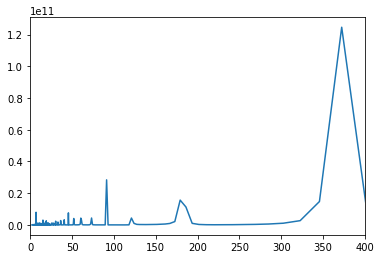

In [409]:
f, asd = signal.periodogram(flot)
# plt.figure()
plt.plot(1/f, asd)
plt.xlim(0, 400)

In [410]:
picos = pd.DataFrame(asd, 1/(f), columns=["potencia"])
picos = picos.sort_values(by="potencia",ascending=False).reset_index().head(12)
picos.columns = ["periodo", "potencia"]

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide



In [411]:
picos

periodo      potencia
0   372.153846  1.246128e+11
1    91.283019  2.840338e+10
2   179.185185  1.562952e+10
3   345.571429  1.474192e+10
4   186.076923  1.128929e+10
5     7.021771  7.963636e+09
6    45.641509  7.589072e+09
7   403.166667  5.022084e+09
8    73.303030  4.346734e+09
9   120.950000  4.330696e+09
10   60.475000  4.291014e+09
11   52.021505  4.050108e+09

In [412]:
picos["periodo"].iplot()

## plott

In [259]:
t = np.linspace(-10, 10, 2000)

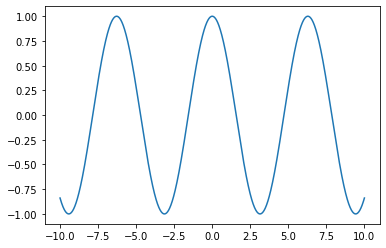

In [260]:
plt.plot(t, np.cos(t))

In [265]:
col = pd.DataFrame(np.sin(np.sin(t)), columns = ["y"])
col["x"] = t

In [266]:
col.iplot(x = "x", y = "y" )